# Error Visualization
This notebook categorizes the errors encountered when running the AutoML benchmark creates visualizations that show when, where, and why errors happen.


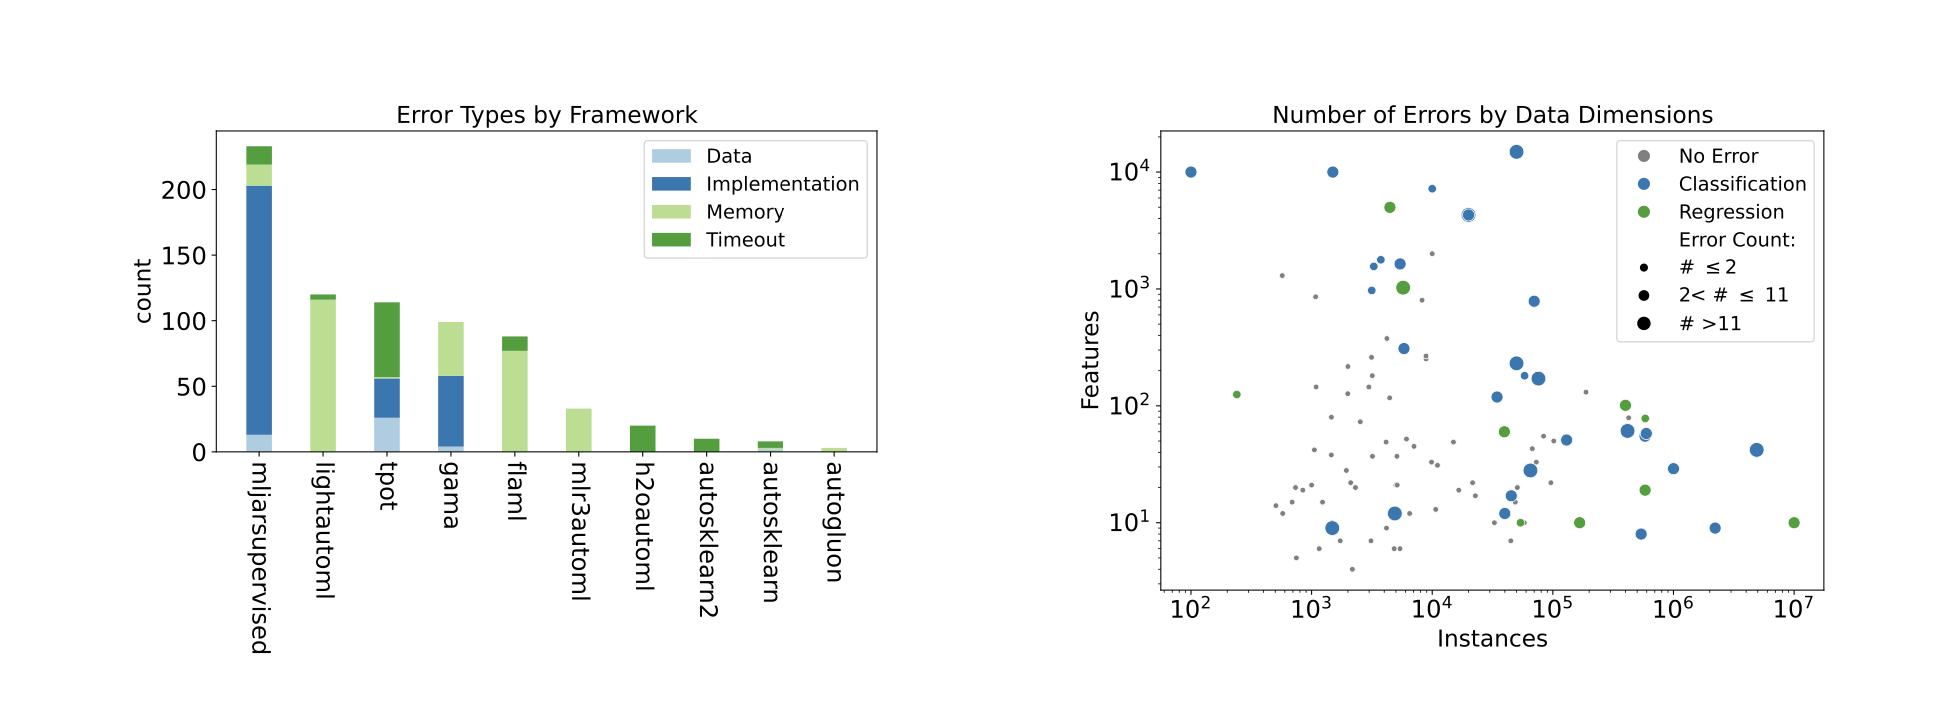

### Loading Data

In [601]:
import itertools
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_processing import get_print_friendly_name

In [602]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [603]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results["framework"] = results["framework"].apply(get_print_friendly_name)
results = results[results["framework"] != "NaiveAutoML"]

## Categorizing Errors

In [604]:
with_errors = results[~results["info"].isna()][["framework", "task", "fold", "constraint", "info"]]

In [605]:
TIMEOUT_PATTERN = re.compile("Interrupting thread MainThread \[ident=\d+\] after \d+s timeout.")
def is_timeout(message: str) -> bool:
    if re.search(TIMEOUT_PATTERN, message):
        return True
    return False

In [606]:
def is_memory(message: str) -> bool:
    if "Cannot allocate memory" in message:
        return True
    if "exit status 134" in message:
        return True
    if "exit status 137" in message:
        return True
    if "exit status 139" in message:
        return True
    if "exit status 143" in message:
        return True
    if "std::bad_alloc" in message:
        return True
    if "Dummy prediction failed with run state StatusType.MEMOUT" in message:
        return True  # autosklearn
    if "This could be caused by a segmentation fault while calling the function or by an excessive memory usage" in message:
        return True  # lightautoml
    if "OutOfMemoryError: GC overhead limit exceeded" in message:
        return True  # H2O
    return False

In [607]:
def is_data(message: str) -> bool:
    if "NoResultError: y_true and y_pred contain different number of classes" in message:
        return True
    return False

In [608]:
def is_implementation(message: str) -> bool:
    if "Unsupported metric `auc` for regression problems" in message:
        return True  # FLAML produces NaN predictions
    if "A pipeline has not yet been optimized. Please call fit() first." in message:
        return True  # TPOT
    if message == "NoResultError: probability estimates are not available for loss='hinge'":
        return True  # TPOT
    if  "object has no attribute 'predict_proba'" in message:
        return True  # TPOT
    if "'NoneType' object is not iterable" in message:
        return True  # GAMA
    if "The least populated class in y has only 1 member, which is too few." in message:
        return True  # GAMA
    if message == "NoResultError: ":
        return True  # GAMA
    if "Ran out of input" in message:
        return True  # GAMA
    if "Python int too large to convert to C ssize_t" in message:
        return True  # GAMA
    if "invalid load key, " in message:
        return True  # GAMA
    if "Pipeline finished with 0 models for some reason." in message:
        return True  # Light AutoML
    if "No models produced. \nPlease check your data or submit" in message:
        return True  # MLJar
    if "The feature names should match those that were passed during fit" in message:
        return True  # MLJar
    if re.search("At position \d+ should be feature with name", message):
        return True  # MLJar
    if "Object of type float32 is not JSON serializable" in message:
        return True  # MLJar
    if "Ensemble_prediction_0_for_" in message:
        return True  # MLJar
    if "NeuralNetFastAI_BAG_L1'" in message:
        return True  # AutoGluon
    if "No learner was chosen in the initial phase." in message:
        return True  # NaiveAutoML
    return False

In [609]:
def needs_investigation(message: str) -> bool:
    if "'NoneType' object has no attribute 'name'" in message:
        return True  # AutoGluon
    return False

In [610]:
def needs_rerun(message: str) -> bool:
    if "NoResultError: 'e'" in message:
        return True  # Autosklearn artifact save bug
    if "Auto-sklearn does not yet support sparse pandas Series" in message:
        return True  # Autosklearn
    if re.search("Exception: File: /input/org/openml/www/datasets/\d+/dataset_\d+.pq", message):
        return True
    return False

In [611]:
checks = dict(
    timeout=is_timeout,
    memory=is_memory,
    data=is_data,
    implementation=is_implementation,
    rerun=needs_rerun,
    investigate=needs_investigation,
)

def classify_error(message: str):
    for type_, check in checks.items():
        if check(message):
            return type_
    return "unknown"

In [612]:
with_errors["error_type"] = with_errors["info"].apply(classify_error)

#### Expand the above check functions until no unknown errors are left below

In [613]:
if n_errors:= len(with_errors[with_errors["error_type"] == "unknown"]["info"].unique()):
    print(n_errors)
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0])
    print(with_errors[with_errors["error_type"] == "unknown"].iloc[0]["info"])

#### Run below to find runs to redo

In [614]:
results.loc[with_errors[(with_errors["error_type"] == "rerun" )].index]

,id,task,framework,constraint,fold,type,result,metric,mode,version,...,mae,r2,rmse,source,infer_batch_size_df_1,infer_batch_size_file_1,infer_batch_size_file_10,infer_batch_size_file_100,infer_batch_size_file_1000,infer_batch_size_file_10000
8016,openml.org/t/359986,robert,H2OAutoML,4h8c_gp3,1,multiclass,NaN,neg_logloss,aws.docker,3.40.0.4,...,NaN,NaN,NaN,2023Q2,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizing Errors by Framework

In [615]:
one_hour = with_errors[with_errors["constraint"] == "1h8c_gp3"]
error_counts = one_hour.groupby(["framework", "error_type"], as_index=False).count()    

In [616]:
frameworks = list(one_hour.groupby("framework").count().task.sort_values(ascending=False).index)
error_types = error_counts["error_type"].unique()

In [617]:
all_combinations = pd.DataFrame(itertools.product(error_types, frameworks), columns=["error_type", "framework"])
error_counts = pd.concat([error_counts, all_combinations]).drop_duplicates(subset=["error_type", "framework"], keep='first')
error_counts = error_counts.fillna(0)

In [654]:
color_by_error_type = {
    "data": "#a6cee3",  #light blue
    "implementation": "#2078b4", # dark blue
    "memory": "#b2df8a", #light green
    "timeout": "#32a02d",  #dark green
    "rerun": "#999999",
    "investigate": "#cccccc",
}
assert all(error in color_by_error_type for error in error_types)
color_by_error_type = {k: v for k, v in color_by_error_type.items() if k in error_types}

In [655]:
errors_by_framework = {
    error_type: [
        error_counts[(error_counts["error_type"] == error_type) & (error_counts["framework"] == framework)]["info"].iloc[0]
        for framework in frameworks
    ]
    for error_type in color_by_error_type
}

Text(0.5, 1.0, 'Error types by framework')

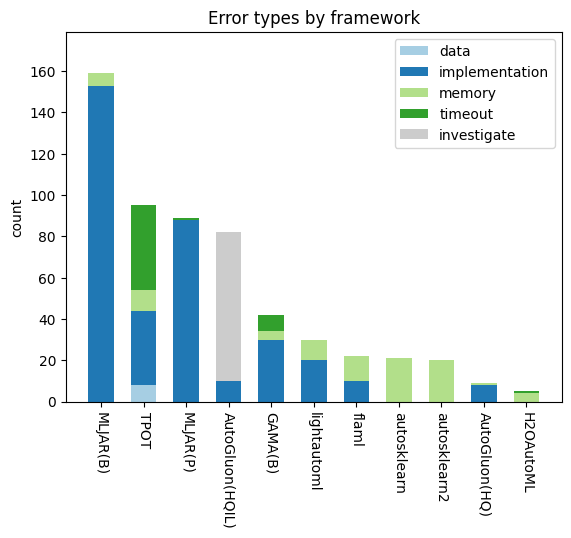

In [656]:
fig, ax = plt.subplots()

bottoms = np.zeros(len(frameworks))
for error_type, counts in errors_by_framework.items():
    ax.bar(frameworks, counts, label=error_type, bottom=bottoms, width=.6, color=color_by_error_type[error_type])
    bottoms += counts

ax.set_ylim([0, max(bottoms) + 20])
ax.set_ylabel("count")
ax.tick_params(axis="x", which="major", rotation=-90)
ax.legend(loc="upper right")
ax.set_title("Error types by framework")

## Visualizing Errors by Dataset Size

In [657]:
errors_by_task = one_hour.groupby("task").count()["info"]

In [658]:
metadata_path = DATA_DIRECTORY / "metadata.csv"
if metadata_path.is_file():
    metadata = pd.read_csv(metadata_path)
else:
    import openml
    regression = openml.study.get_suite(269)
    classification = openml.study.get_suite(271)
    metadata = openml.datasets.list_datasets(data_id=regression.data+classification.data, output_format="dataframe")
    metadata.to_csv(metadata_path, index=False)

In [659]:
metadata.head()

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
0,3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
1,12,mfeat-factors,1,1,active,ARFF,200.0,10.0,200.0,10.0,217.0,2000.0,0.0,0.0,216.0,1.0
2,23,cmc,1,1,active,ARFF,629.0,4.0,333.0,3.0,10.0,1473.0,0.0,0.0,2.0,8.0
3,31,credit-g,1,1,active,ARFF,700.0,10.0,300.0,2.0,21.0,1000.0,0.0,0.0,7.0,14.0
4,54,vehicle,1,1,active,ARFF,218.0,4.0,199.0,4.0,19.0,846.0,0.0,0.0,18.0,1.0


In [660]:
errors_by_task.head()

task
APSFailure                  10
Airlines_DepDelay_10M       13
Allstate_Claims_Severity     6
Amazon_employee_access       1
Australian                   1
Name: info, dtype: int64

In [685]:
all_results = metadata.set_index("name").join(errors_by_task)
all_results = all_results.fillna(0)
all_results = all_results.rename(columns=dict(info="count"))
errors = all_results[all_results["count"]>0].copy()
no_errors = all_results[all_results["count"]==0].copy()
errors.head()

,did,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,count
name,,,,,,,,,,,,,,,,
kr-vs-kp,3,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0,10.0
cmc,23,1,1,active,ARFF,629.0,4.0,333.0,3.0,10.0,1473.0,0.0,0.0,2.0,8.0,10.0
credit-g,31,1,1,active,ARFF,700.0,10.0,300.0,2.0,21.0,1000.0,0.0,0.0,7.0,14.0,10.0
vehicle,54,1,1,active,ARFF,218.0,4.0,199.0,4.0,19.0,846.0,0.0,0.0,18.0,1.0,10.0
yeast,181,1,1,active,ARFF,463.0,10.0,5.0,10.0,9.0,1484.0,0.0,0.0,8.0,1.0,12.0


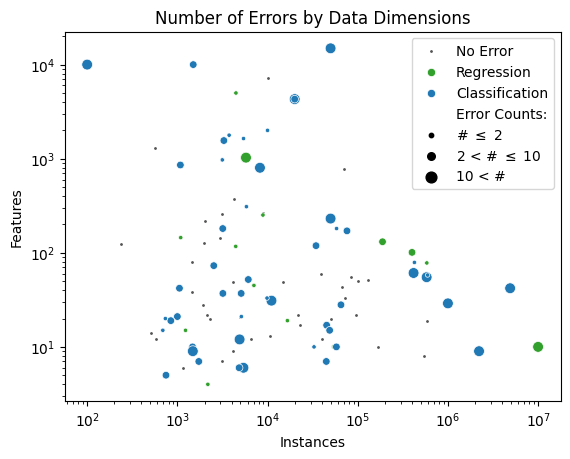

In [707]:
fig, ax = plt.subplots()

errors["marker_size"] = errors["count"].apply(lambda c: 10 if c<3 else (30 if c < 11 else 60))
classification = errors[errors["NumberOfClasses"] > 0]
regression = errors[errors["NumberOfClasses"] == 0]

ax.scatter(no_errors["NumberOfInstances"], no_errors["NumberOfFeatures"], color="#555555", s=1, label="No Error")
ax.scatter(regression["NumberOfInstances"], regression["NumberOfFeatures"], color="#32a02d", s=regression["marker_size"], label="Regression", edgecolors="white", linewidths=.5)
ax.scatter(classification["NumberOfInstances"], classification["NumberOfFeatures"], color="#2078b4", s=classification["marker_size"], label="Classification", edgecolors="white", linewidths=.5)

ax.scatter(0, 0, color="#ffffff", s=60, label="Error Counts:")
ax.scatter(0, 0, color="#000000", s=10, label="# $\leq$ 2")
ax.scatter(0, 0, color="#000000", s=30, label="2 < # $\leq$ 10")
ax.scatter(0, 0, color="#000000", s=60, label="10 < #")

ax.set_xscale("log")
ax.set_xlabel("Instances")
ax.set_yscale("log")
ax.set_ylabel("Features")
ax.set_title("Number of Errors by Data Dimensions")
plt.legend()

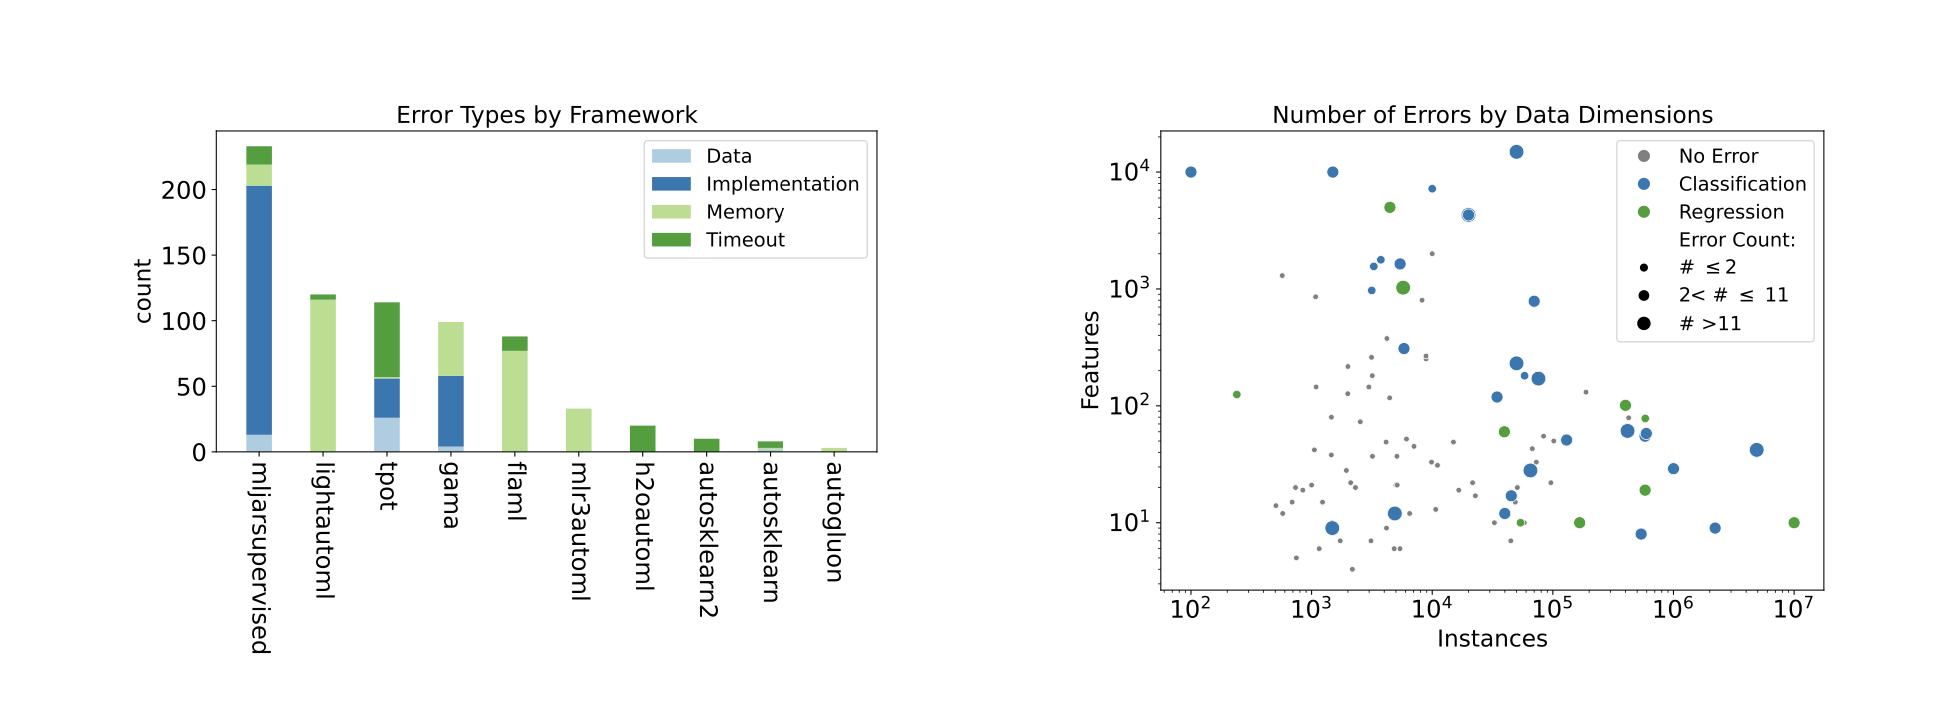
